# Chapter 8 BETA
### Two main objectives of this chapter
#### 1.The first objective of this chapter is to present several different approaches that researchers use to estimate a stock’s beta and empirically examine these measures.¶
#### 2.The second objective is to analyze the cross-sectional relation between market beta and stock returns.¶

### 8.1.1 Estimating Beta
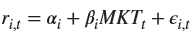
###### where ri,t is the excess return of stock i during period t, MKTt is the excess return of the market portfolio (the market factor) during period t, and 𝜖i,t is the regression residual. 

#### We examine nine different combinations of estimation periods and data frequencies.
#### 1.Five using daily data and four using monthly data. 
#### 2.For the daily data measures, we use period lengths of one, three, six, 12, and 24 months and require 15, 50, 100, 200, and 450 days of valid return data, respectively, to perform the calculation.
#### 3.For the monthly data measures, market beta using monthly excess return observations over the past one, two, three, and five years, requiring 10, 20, 24, and 24 valid monthly excess return observations, respectively.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [9]:
os.chdir(r'D:\Postgraduate\2020\asset pricing\data')
ret = pd.read_csv(os.path.join('中国市场','TRD_Month.csv'))
#daily_data = pd.read_csv(os.path.join('中国市场','TRD_daily.csv'))
code = pd.read_csv(os.path.join('中国市场','Acode.csv'))
ff4 = pd.read_csv(os.path.join('中国市场','fivefactor_monthly.csv'))
#mktcap = pd.read_csv(os.path.join('中国市场','fivefactor_daily.csv'))

In [6]:
def get_month(table,key):
    table[key] = pd.to_datetime(table[key])
    table['year'] = table[key].dt.year
    table['month'] = table[key].dt.month
    return table

def get_month2(table,key):
    table[key] = pd.to_datetime(table[key],format = '%Y%m')
    table['year'] = table[key].dt.year
    table['month'] = table[key].dt.month
    return table

In [70]:
#计算月度超额收益
'''
**1997-2019月度数据
**全A股收益率（包含上证A，深A，科创板，创业板）
Trdmnt:股票收益时间
trdmn:无风险收益时间
'''
ret1 = get_month(ret,'Trdmnt')
ff4 = get_month2(ff4,'trdmn')

#筛选1997-2019
def time(df,t1,t2):
    df = df[(df['year']>=t1)&(df['year']<=t2)]
    return df
ret1 = time(ret1,1997,2019)
ff4 = time(ff4,1997,2019)
ff = ff4['mkt_rf']
ff.index = ff4['trdmn']

#筛选A股
def filt(x1,x2,x3,x4):
    df = pd.merge(ret1,code,on = 'Stkcd')
    df = df[(df['exchcd'] == x1)|(df['exchcd'] == x2)|(df['exchcd'] == x3)|(df['exchcd'] == x4)]
    return df
ret2 = filt(1,4,16,32)

#合并收益率数据计算超额收益

def data(inx,col,value):
    temp = ff4[['year','month','mkt_rf','rf']]
    df = pd.merge(ret2,temp,on = ['year','month'])   #两个表因为交易时间问题，时间并不一致所以通过年份和月份进行合并 
    df['rt'] = df['Mretnd'] - df['rf']
    month_data = pd.pivot(df,index=inx,columns=col,values=value)
    month_data['month_num'] = (month_data.index.year-1997)*12+month_data.index.month   
    return month_data

month_data = data('Trdmnt','Stkcd','rt')
data1 = month_data.shift(-1) 
reg = data1.T  #rt+1
reg.columns = beta_1m.columns

In [ ]:
##筛选日度数据
daily_data = get_month(daily_data,'date')
daily_data = time(daily_data,1997,2019)
daily_data = filt(1,4,16,32)
daily_data['month_num'] = (daily_data['year']-1997)*12 + daily_data['month']

##合并收益率数据与无风险利率
mktcap['date'] =  pd.to_datetime(mktcap['date'])
mktcap = mktcap[['date','mkt','rf']]
daily_data = pd.merge(daily_data,mktcap,on='date')
daily_data['rt'] = daily_data['rt']-daily_data['rf']  #获得超额收益

full_data = pd.pivot(daily_data,index='date',columns='code',values='rt')
full_data['month_num'] = (full_data.index.year-1997)*12+full_data.index.month
mktcap2 = mktcap['mkt']
mktcap2.index = mktcap['date']

In [ ]:
def beta_calculator(data,factor,span,low_limit):
    '''
    用来计算beta的表格函数，输出是某一种计算方式的beta的表格。
    
    输入参数
    ----------
    data是以month_num为columns，code为index，rt为value
    span是每次回归跨度月份数，一年为12
    low_limit是计算beta的最低样本数（天数），一个月为10，三个月为50等
    输出
    -------
    index为股票代码，columns为月份编号，value为对应规则算出beta 的df
    '''
    X = pd.DataFrame()
    for i in range(max(data['month_num'])-span+1):
        same_time_data = data[(data['month_num']>i)&(data['month_num']<=i+span)]
        same_time = []
        code_list = list(same_time_data.columns[:-1])
        for code in code_list:
            temp_data = same_time_data[code]
            temp_data.name = 'rt'
            reg_data = pd.concat([temp_data,factor],axis=1,join='inner')
            if reg_data['rt'].notna().sum() >= low_limit:
                model = smf.ols('rt~mkt_rf',reg_data,missing='drop').fit()
                beta = model.params[1]
            else:
                beta = np.nan
            same_time.append(beta)
        same_time = pd.Series(same_time,index = code_list,name = i+span)
        X = pd.concat([X,same_time],axis=1)
    return X

beta_1m = beta_calculator(full_data,mktcap2,1,10)
beta_3m = beta_calculator(full_data,mktcap2,3,50)
beta_6m = beta_calculator(full_data,mktcap2,6,100)
beta_12m = beta_calculator(full_data,mktcap2,12,200)
beta_24m = beta_calculator(full_data,mktcap2,24,450)
beta_1y = beta_calculator(month_data,ff,12,10)
beta_2y = beta_calculator(month_data,ff,24,20)
beta_3y = beta_calculator(month_data,ff,36,24)
beta_5y = beta_calculator(month_data,ff,60,24)

### 8.1.2 Two Implemental Beta
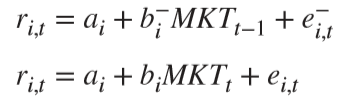
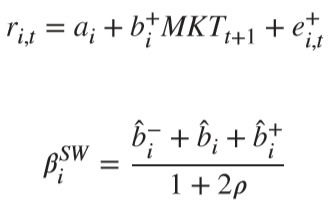
#### 1.We require 200 valid excess return observations during the estimation period to calculate 𝛽SW
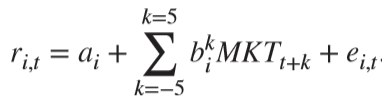
#### 2.We require a minimum of 200 data points to perform the calculation for𝛽D.

In [ ]:
def beta_calculator_sw(data,factor):
        '''
    用来计算beta_sw的表格函数，输出是beta_sw计算方式的beta的表格。
    
    输入参数
    ----------
    data是有每只股票每月日度收益和市场超额收益信息的表格，变量命名month_num,code,rt,mkt
    span是每次回归跨度月份数，一年为12
    low_limit是计算beta的最低样本数（天数），一个月为15，三个月为40等
    
    输出
    -------
    index为股票代码，columns为月份编号，value为对应规则算出beta 的df
    '''
    X = pd.DataFrame()
    rou = pearsonr(factor['mkt'][1:],factor['mkt'][:-1])[0]
    mktcap1 = mktcap2 = mktcap3 = factor[['date','mkt']]
    mktcap1['date'] = mktcap1['date'] + dt.timedelta(days=1)
    mktcap3['date'] = mktcap3['date'] + dt.timedelta(days=-1)
    for i in range(1,max(data['month_num'])-12):
        same_time_data = data[(data['month_num']>i)&(data['month_num']<=i+12)]
        same_time = []
        code_list = list(set(same_time_data['code']))
        for code in code_list:
            temp_data = same_time_data[same_time_data['code'] == code]
            reg_data1 = pd.merge(temp_data,mktcap1,on='date')
            reg_data2 = pd.merge(temp_data,mktcap2,on='date')
            reg_data3 = pd.merge(temp_data,mktcap3,on='date')
            reg_data1 = reg_data1[['rt','mkt']]
            reg_data2 = reg_data2[['rt','mkt']]
            reg_data3 = reg_data3[['rt','mkt']]
            if reg_data2['rt'].notna().sum()>=200:
                model1 = smf.ols('rt~mkt',reg_data1,missing='drop').fit()
                model2 = smf.ols('rt~mkt',reg_data2,missing='drop').fit()
                model3 = smf.ols('rt~mkt',reg_data3,missing='drop').fit()
                beta1 = model1.params[1]
                beta2 = model2.params[1]
                beta3 = model3.params[1]
                beta = (beta1+beta2+beta3)/(1+2*rou)
            else:
                beta = np.nan
            same_time.append(beta)
        same_time = pd.Series(same_time,index = code_list,name = i+12)
        X = pd.concat([X,same_time],axis=1)
    return X

full_data3 = daily_data[['code','rt','date','month_num']]
beta_sw = beta_calculator_sw(full_data3,mktcap)
beta_sw.columns = beta_sw.columns+1

In [ ]:
def beta_calculator_d(data,factor):
            '''
    用来计算beta_d的表格函数，输出是beta_d计算方式的beta的表格。
    
    输入参数
    ----------
    data是以month_num为columns，code为index，rt为value
    span是每次回归跨度月份数，一年为12
    low_limit是计算beta的最低样本数（天数），一个月为15，三个月为40等
    
    输出
    -------
    index为股票代码，columns为月份编号，value为对应规则算出beta 的df
    '''
    X = pd.DataFrame()
    mkt = pd.DataFrame()
    for  k in range(6):
        x1 = factor.shift(k)
        x2 = factor.shift(-k)
        if k==0:
            mkt = pd.concat([mkt,x1],axis=1)
        else:
            mkt = pd.concat([mkt,x1],axis=1)
            mkt = pd.concat([mkt,x2],axis=1)
    mkt.columns = ['mkt6','mkt5','mkt7','mkt4','mkt8','mkt3','mkt9','mkt2','mkt10','mkt1','mkt11']
    mkt = mkt.dropna()
    for i in range(1,max(data['month_num'])-12):
        same_time_data = data[(data['month_num']>i)&(data['month_num']<=i+12)]
        same_time = []
        code_list = same_time_data.columns[:-1]
        for code in code_list:
            temp_data = same_time_data[code]
            temp_data.name = 'rt'
            reg_data = pd.concat([temp_data,mkt],axis=1,join='inner')
            if reg_data['rt'].notna().sum()>=200:
                model = smf.ols('rt~mkt6+mkt5+mkt7+mkt4+mkt8+mkt3+mkt9+mkt2+mkt10+mkt1+mkt11',reg_data,missing='drop').fit()
                beta = sum(model.params[1:])
            else:
                beta = np.nan
            same_time.append(beta)
        same_time = pd.Series(same_time,index = code_list,name = i+12)
        X = pd.concat([X,same_time],axis=1)
        print(i)
    return X

beta_d = beta_calculator_d(full_data,mktcap2)

In [12]:
beta_1m = pd.read_csv(os.path.join('中国市场','beta_1m.csv'),index_col=0)
beta_3m = pd.read_csv(os.path.join('中国市场','beta_3m.csv'),index_col=0)
beta_6m = pd.read_csv(os.path.join('中国市场','beta_6m.csv'),index_col=0)
beta_12m = pd.read_csv(os.path.join('中国市场','beta_12m.csv'),index_col=0)
beta_24m = pd.read_csv(os.path.join('中国市场','beta_24m.csv'),index_col=0)
beta_1y = pd.read_csv(os.path.join('中国市场','beta_1y.csv'),index_col=0)
beta_2y = pd.read_csv(os.path.join('中国市场','beta_2y.csv'),index_col=0)
beta_3y = pd.read_csv(os.path.join('中国市场','beta_3y.csv'),index_col=0)
beta_5y = pd.read_csv(os.path.join('中国市场','beta_5y.csv'),index_col=0)
beta_sw = pd.read_csv(os.path.join('中国市场','beta_sw.csv'),index_col=0)
beta_d = pd.read_csv(os.path.join('中国市场','beta_d.csv'),index_col=0)

In [17]:
def beta_statistic(list_of_beta,name_of_beta):
    X = pd.DataFrame()
    for i in range(len(list_of_beta)):
        x = list_of_beta[i]
        new = pd.Series([x.mean().mean(),x.std().mean(),x.skew().mean(),x.kurt().mean(),x.min().mean(),x.quantile(.05).mean(),x.quantile(.25).mean(),x.median().mean(),x.quantile(.75).mean(),x.quantile(.95).mean(),x.max().mean(),x.count().mean()],
                         index = ['Mean','SD','Skew','Kurt','Min','5%','25%','Median','75%','95%','Max','n'],name = name_of_beta[i])
        X = pd.concat([X,new],axis=1)
    X = X.T
    X = X.applymap(lambda x:round(x, 2))
    return X

df_list = [beta_1m,beta_3m,beta_6m,beta_12m,beta_24m,beta_1y,beta_2y,beta_3y,beta_5y,beta_sw,beta_d]

def drop():
    beta = []
    for i in df_list:
        if i.columns[-1] == '276':
            i = i.drop('276',axis = 1)
        beta.append(i)
    return beta

beta_list = drop()

beta_name_list = ['beta_1m','beta_3m','beta_6m','beta_12m','beta_24m','beta_1y','beta_2y','beta_3y','beta_5y','beta_sw','beta_d']
table1 = beta_statistic(beta_list,beta_name_list)
table1

D:\Python\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,25%,5%,75%,95%,Kurt,Max,Mean,Median,Min,SD,Skew,n
beta_1m,0.80,0.30,1.37,1.83,115.50,11.03,1.08,1.09,-6.02,0.78,0.22,1778.77
beta_3m,0.89,0.54,1.29,1.59,24.35,3.17,1.09,1.10,-0.97,0.35,-0.33,1706.92
beta_6m,0.92,0.61,1.26,1.50,22.83,2.68,1.08,1.10,-0.44,0.29,-0.20,1668.40
beta_12m,0.95,0.66,1.24,1.42,18.14,2.42,1.08,1.10,-0.15,0.25,-0.19,1620.75
beta_24m,0.98,0.72,1.21,1.35,11.14,1.82,1.08,1.10,0.15,0.20,-0.58,1324.67
beta_1y,0.77,0.27,1.39,1.99,11.77,5.15,1.09,1.07,-1.91,0.56,0.60,1700.13
beta_2y,0.85,0.50,1.31,1.73,16.06,4.13,1.09,1.07,-0.79,0.40,0.87,1639.60
beta_3y,0.89,0.59,1.28,1.64,26.27,4.34,1.10,1.08,-0.99,0.36,1.27,1720.46
beta_5y,0.92,0.65,1.26,1.57,52.12,5.06,1.10,1.08,-2.34,0.34,1.50,1850.02
beta_sw,2.66,1.85,3.46,3.98,17.91,6.75,3.03,3.08,-0.39,0.70,-0.19,1624.82


### 8.2 CORRELATIONS

In [20]:
def personcorr_calculator(dataname1,dataname2):
    X = []
    if len(dataname1.columns)>=len(dataname2.columns):
        month_list = dataname2.columns
    else:
        month_list = dataname1.columns
    for y in month_list:
        x1 = dataname1[y]
        x2 = dataname2[y]
        x = pd.concat([x1,x2],axis=1)
        x = x.dropna(axis=0,how='any')
        person_corr = x.corr('pearson').iloc[0,1]
        X.append(person_corr)
    X = pd.Series(X)
    x = X.mean()
    return x

def spearman_calculator(dataname1,dataname2):
    X = []
    if len(dataname1.columns)>=len(dataname2.columns):
        month_list = dataname2.columns
    else:
        month_list = dataname1.columns
    for y in month_list:
        x1 = dataname1[y]
        x2 = dataname2[y]
        x = pd.concat([x1,x2],axis=1)
        x = x.dropna(axis=0,how='any')
        spearman_corr = x.corr(method = 'spearman').iloc[0,1]
        X.append(spearman_corr)
    X = pd.Series(X)
    x = X.mean()
    return x

In [21]:
def beta_in_list(list_of_beta,name_of_beta):
    ##beta的list顺序和名字顺序要完全对应
    X = pd.DataFrame([],index = name_of_beta,columns = name_of_beta)
    for i in range(len(list_of_beta)):
        for j in range(len(list_of_beta)):
            if i<=j:
                X.iloc[i,j] = spearman_calculator(list_of_beta[i],list_of_beta[j])
            else:
                X.iloc[i,j] = personcorr_calculator(list_of_beta[i],list_of_beta[j])
    X = X.applymap(lambda x:round(x, 2))
    return X

table2 = beta_in_list(beta_list,beta_name_list)            
table2

,beta_1m,beta_3m,beta_6m,beta_12m,beta_24m,beta_1y,beta_2y,beta_3y,beta_5y,beta_sw,beta_d
beta_1m,1.00,0.69,0.57,0.48,0.41,0.22,0.20,0.19,0.18,0.48,0.29
beta_3m,0.66,1.00,0.82,0.68,0.56,0.33,0.30,0.27,0.25,0.68,0.42
beta_6m,0.56,0.80,1.00,0.83,0.68,0.40,0.37,0.33,0.30,0.83,0.50
beta_12m,0.47,0.68,0.82,1.00,0.83,0.46,0.44,0.41,0.36,1.00,0.56
beta_24m,0.41,0.59,0.71,0.84,1.00,0.38,0.52,0.51,0.46,0.83,0.48
beta_1y,0.20,0.32,0.39,0.43,0.38,1.00,0.70,0.56,0.47,0.46,0.67
beta_2y,0.19,0.30,0.36,0.43,0.51,0.69,1.00,0.81,0.65,0.44,0.54
beta_3y,0.16,0.26,0.32,0.39,0.50,0.55,0.80,1.00,0.80,0.41,0.47
beta_5y,0.14,0.22,0.27,0.33,0.43,0.44,0.62,0.80,1.00,0.36,0.42
beta_sw,0.47,0.68,0.82,1.00,0.84,0.43,0.43,0.39,0.33,1.00,0.56


### 8.3 PERSISTENCE

In [44]:
def Persistence_calculator(df):
    temp = winsorize(df,limits=(0.005, 0.005))
    temp1 = pd.DataFrame(temp)
    corr = temp1.corr()
    delay_list = [1,3,6,12,24,36,48,60,120]
    X = pd.DataFrame([],index = df.columns,columns = delay_list)
    for x in range(len(df.columns)):
        for y in range(9):
            if x+delay_list[y] < df.shape[1]:
                X.iloc[x,y] = corr.iloc[x,x+delay_list[y]]
    stats = X.mean()
    return stats

def beta_autocorr(list_of_beta,name_of_beta):
    X = pd.DataFrame()
    for i in list_of_beta:
        x = Persistence_calculator(i)
        X = pd.concat([X,x],axis=1)
    del_list = [1,2,3,4,3,4,5,7,3,3]
    for j in range(10):
        k = del_list[j]
        X.iloc[:k,j+1] = np.nan
    X.columns = name_of_beta
    X = X.applymap(lambda x:round(x, 2))
    return X
      
table3 = beta_autocorr(beta_list,beta_name_list)
table3

,beta_1m,beta_3m,beta_6m,beta_12m,beta_24m,beta_1y,beta_2y,beta_3y,beta_5y,beta_sw,beta_d
1,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.22,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.17,0.35,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.12,0.26,0.34,0.47,NaN,0.12,NaN,NaN,NaN,0.47,0.19
24,0.08,0.18,0.24,0.31,0.47,0.08,0.16,NaN,NaN,0.32,0.14
36,0.06,0.13,0.18,0.24,0.35,0.08,0.13,0.16,NaN,0.24,0.11
48,0.05,0.11,0.15,0.20,0.29,0.05,0.10,0.13,NaN,0.20,0.09
60,0.04,0.10,0.14,0.18,0.26,0.06,0.08,0.10,0.13,0.18,0.08
120,0.02,0.05,0.08,0.11,0.17,0.03,0.06,0.07,0.11,0.11,0.07


### 8.4 Equal-Weighted Portfolios

In [56]:
monthly_rt = data('Trdmnt','Stkcd','rt').T
monthly_mkt = data('Trdmnt','Stkcd','Msmvttl').T  
monthly_rt.columns = beta_1m.columns
monthly_mkt.columns = beta_1m.columns

ff1 = ff4[['year','month','mkt_rf']]
ff1['month_num'] = (ff1['year']-1997)*12+ff1['month']
ff1 = ff1[['month_num','mkt_rf']].set_index('month_num')

D:\Python\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
def capm_reg_equal(beta,rt,mkt_rf):
    mkt_rf.index = rt.columns
    beta_list = pd.DataFrame()
    rt_list = pd.DataFrame()
    for i in beta.columns:
        temp_beta = beta[i]
        temp_rt = rt[i]
        x = pd.concat([temp_beta,temp_rt],axis=1)
        x.columns = ['beta','rt']
        x['group'] = pd.qcut(temp_beta,10,labels=False)
        x = x.dropna()
        beta_avg_i = x.groupby('group')['beta'].mean()
        rt_avg_i = x.groupby('group')['rt'].mean()
        beta_list = pd.concat([beta_list,beta_avg_i],axis=1)
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    beta_list.columns = beta.columns
    rt_list.columns = beta.columns
    beta_list = beta_list.T
    rt_list = rt_list.T
    beta_list.columns = range(1,11)
    rt_list.columns = range(1,11)
    beta_list['10-1'] = beta_list[10] - beta_list[1]
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    alpha = []
    alpha_t = []
    for j in rt_list.columns:
        reg_list = pd.concat([rt_list[j],mkt_rf],axis=1,join='inner')
        reg_list.columns = ['rt','mkt_rf']
        reg_list = reg_list.dropna()
        model = smf.ols('rt~mkt_rf',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
    beta_avg = beta_list.mean()
    rt_avg = rt_list.mean()
    alpha = pd.Series(alpha,index = beta_avg.index)
    alpha_t = pd.Series(alpha_t,index = beta_avg.index)
    X = pd.concat([beta_avg,rt_avg,alpha,alpha_t],axis=1).T
    X.index = ['beta','excess return','alpha','alpha_t']
    return X

def table4(list_of_beta,rt,mkt_rf):
    X = pd.DataFrame()
    for i in list_of_beta:
        x = capm_reg_equal(i,rt,mkt_rf)
        X = pd.concat([X,x])
    X = X.applymap(lambda x:round(x, 2))
    return X

table4 = table4(beta_list,monthly_rt,ff1)  
table4

,1,2,3,4,5,6,7,8,9,10,10-1
beta,0.21,0.63,0.80,0.93,1.04,1.14,1.25,1.37,1.54,1.90,1.70
excess return,0.06,0.02,0.01,0.01,0.00,0.00,-0.00,-0.00,0.00,0.02,-0.03
alpha,0.05,0.02,0.01,0.00,-0.00,-0.01,-0.01,-0.01,-0.01,0.01,-0.03
alpha_t,9.33,7.93,3.72,0.17,-2.73,-4.44,-5.52,-5.31,-3.35,4.37,-8.92
beta,0.48,0.77,0.89,0.98,1.06,1.13,1.21,1.30,1.40,1.64,1.16
excess return,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,-0.01
alpha,0.02,0.01,0.01,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.02
alpha_t,6.35,5.59,3.50,2.12,1.23,0.01,-0.30,-0.74,-0.63,0.41,-4.10
beta,0.56,0.81,0.92,1.00,1.07,1.13,1.19,1.26,1.35,1.54,0.97
excess return,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,-0.01


### 8.5 Equal-Weighted Portfolios

In [68]:
def capm_reg_mktweight(beta,rt,mkt,mkt_rf):
    mkt_rf.index = rt.columns
    beta_list = pd.DataFrame()
    rt_list = pd.DataFrame()
    for i in beta.columns:
        temp_beta = beta[i]
        temp_rt = rt[i]
        temp_mkt = mkt[i]
        x = pd.concat([temp_beta,temp_rt,temp_mkt],axis=1)
        x.columns = ['beta','rt','mktcap']
        x['rt*mkt'] = x['rt']*x['mktcap']
        x = x.dropna()
        x['group'] = pd.qcut(temp_beta,10,labels=False)
        beta_avg_i = x.groupby('group')['beta'].mean()
        rt_avg_i = x.groupby('group')['rt*mkt'].sum()/x.groupby('group')['mktcap'].sum()
        beta_list = pd.concat([beta_list,beta_avg_i],axis=1)
        rt_list = pd.concat([rt_list,rt_avg_i],axis=1)
    beta_list.columns = beta.columns
    rt_list.columns = beta.columns
    beta_list = beta_list.T
    rt_list = rt_list.T
    beta_list.columns = range(1,11)
    rt_list.columns = range(1,11)
    beta_list['10-1'] = beta_list[10] - beta_list[1]
    rt_list['10-1'] = rt_list[10] - rt_list[1]
    alpha = []
    alpha_t = []
    for j in rt_list.columns:
        reg_list = pd.concat([rt_list[j],mkt_rf],axis=1,join='inner')
        reg_list.columns = ['rt','mkt']
        model = smf.ols('rt~mkt',reg_list).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        alpha.append(model.params[0])
        alpha_t.append(model.tvalues[0])
    beta_avg = beta_list.mean()
    rt_avg = rt_list.mean()
    alpha = pd.Series(alpha,index = beta_avg.index)
    alpha_t = pd.Series(alpha_t,index = beta_avg.index)
    X = pd.concat([beta_avg,rt_avg,alpha,alpha_t],axis=1).T
    X.index = ['beta','excess return','alpha','alpha_t']
    return X     

capm_reg_mktweight(beta_12m,monthly_rt,monthly_mkt,ff1)

def table5(list_of_beta,rt,mkt,mkt_rf):
    X = pd.DataFrame()
    for i in list_of_beta:
        x = capm_reg_mktweight(i,rt,mkt,mkt_rf)
        X = pd.concat([X,x])
    X = X.applymap(lambda x:round(x, 2))
    return X   

table5 = table5(beta_list,monthly_rt,monthly_mkt,ff1)
table5

,1,2,3,4,5,6,7,8,9,10,10-1
beta,0.21,0.63,0.80,0.93,1.04,1.14,1.25,1.37,1.54,1.90,1.70
excess return,0.04,0.02,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.04,-0.01
alpha,0.03,0.01,0.01,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.03,-0.01
alpha_t,7.22,6.12,2.77,2.07,-1.69,-2.40,-1.02,-1.31,0.96,7.55,-1.61
beta,0.48,0.77,0.89,0.98,1.06,1.13,1.21,1.30,1.40,1.64,1.16
excess return,0.02,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.00
alpha,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.01,-0.00
alpha_t,4.49,5.10,4.99,4.16,4.40,3.43,2.39,1.64,2.25,3.98,-0.83
beta,0.56,0.81,0.92,1.00,1.07,1.13,1.19,1.26,1.35,1.54,0.97
excess return,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,-0.00


### Fama-Macbeth Regression

In [76]:
def FM_regression1(df1,df2):
    coefs = []
    adj_R = []
    number = []

    for i in df2.columns:       
        temp_beta = df2[i]
        temp_rt = df1[i]
        x = pd.concat([temp_beta,temp_rt],axis=1)
        x.columns = ['beta','rt']
        temp = x.dropna()
        number.append(len(temp)) #样本量
        temp['beta'] = winsorize(temp['beta'], limits=(0.005, 0.005))
        Y = temp['rt']
        X = temp['beta']
        model = sm.OLS(Y.values,sm.add_constant(X).values).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
        coefs.append(model.params)
        adj_R.append(model.rsquared_adj)
    result = pd.DataFrame(coefs)
    result['adj_R'] = adj_R
    result['n'] = number
    
    return result

In [77]:
def NWtest_1sample(a, lags=6):
    adj_a = np.array(a)
    # 对常数回归
    model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return adj_a.mean(), float(model.tvalues)

In [78]:
def table6(beta,name):
    temp = pd.DataFrame()
    for i in beta_list:
        data = FM_regression1(reg,i)
        value1 = data.iloc[:, :-2].apply(NWtest_1sample)
        value1 = np.array([list(x) for x in value1.values]).reshape(-1)
        
        value2 = data.iloc[:, -2:].mean().values
        value = pd.Series(list(value1) + list(value2))
        temp = pd.concat([temp,value],axis = 1) 
    temp.index = ['intercept','','beta','','Adj_R2','n']
    temp.columns = name
    return temp

table6 = table6(beta_list,beta_name_list)
table61.iloc[:-1,:] = table6[:-1,:].apply(lambda x:round(x, 3))
table61.iloc[-1,:] = table61.iloc[-1,:].apply(lambda x: int(x)) 
table61

D:\Python\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,beta_1m,beta_3m,beta_6m,beta_12m,beta_24m,beta_1y,beta_2y,beta_3y,beta_5y,beta_sw,beta_d
intercept,0.005,0.010,0.013,0.014,0.014,0.012,0.014,0.014,0.013,0.014,0.013
,0.684,1.438,1.826,1.875,1.937,1.759,2.006,1.936,1.810,1.848,1.875
beta,0.006,0.001,-0.002,-0.002,-0.001,-0.001,-0.002,-0.002,-0.001,-0.001,-0.002
,2.804,0.209,-0.508,-0.459,-0.321,-0.393,-0.834,-0.666,-0.242,-0.432,-0.878
Adj_R2,0.016,0.021,0.022,0.020,0.020,0.014,0.014,0.012,0.010,0.020,0.018
n,1769.000,1698.000,1654.000,1598.000,1311.000,1668.000,1601.000,1665.000,1771.000,1602.000,1602.000
